In [1]:
import torch

In [2]:
### Adopted from https://github.com/i404788/s5-pytorch/blob/master/s5/jax_compat.py

import numpy as np
from functools import partial
from typing import overload, Callable, Iterable, List, TypeVar, Any, Literal, Union, Sequence, Tuple, Optional

import torch
from jax.tree_util import tree_flatten, tree_unflatten


T = TypeVar("T")
T1 = TypeVar("T1")
T2 = TypeVar("T2")
T3 = TypeVar("T3")


@overload
def safe_map(f: Callable[[T1], T], __arg1: Iterable[T1]) -> List[T]: ...


@overload
def safe_map(f: Callable[[T1, T2], T], __arg1: Iterable[T1], __arg2: Iterable[T2]) -> List[T]: ...


@overload
def safe_map(f: Callable[[T1, T2, T3], T], __arg1: Iterable[T1], __arg2: Iterable[T2], __arg3: Iterable[T3]) -> List[T]: ...


@overload
def safe_map(f: Callable[..., T], __arg1: Iterable[Any], __arg2: Iterable[Any], __arg3: Iterable[Any], __arg4: Iterable[Any], *args) -> List[T]: ...


def safe_map(f, *args):
    args = list(map(list, args))
    n = len(args[0])
    for arg in args[1:]:
        assert len(arg) == n, f'length mismatch: {list(map(len, args))}'
    return list(map(f, *args))



def slice_along_axis(start, end, stride=None, axis=0):
    return (slice(None),) * axis + (slice(start, end, stride),)

def _interleave(a, b, axis):
    # https://stackoverflow.com/questions/60869537/how-can-i-interleave-5-pytorch-tensors
    if b_trunc := (a.shape[axis] == b.shape[axis] + 1):
        pad = [0, 0] * b.ndim
        pad[(b.ndim-axis-1)*2+1] = 1 # +1=always end of dim, pad-order is reversed so start is at end
        b = torch.nn.functional.pad(b, pad)

    stacked = torch.stack([a, b], dim=axis+1)
    interleaved = torch.flatten(stacked, start_dim=axis, end_dim=axis+1)
    if b_trunc:
        # TODO: find torch alternative for slice_along axis for torch.jit.script to work
        interleaved = interleaved[slice_along_axis(0, b.shape[axis]+a.shape[axis]-1, axis=axis)]
    return interleaved

def test_interleave():
    x,y = torch.randn(1, 32, 32), torch.randn(1, 32, 32)
    v = _interleave(x,y, axis=1)
    assert v.shape == (1,64,32)
    assert (v[:, 0] == x[:, 0]).all()
    assert (v[:, 1] == y[:, 0]).all()
    assert (v[:, 2] == x[:, 1]).all()
    assert (v[:, 3] == y[:, 1]).all()
    assert (v[:, 4] == x[:, 2]).all()

    v = _interleave(x,y, axis=2)
    assert v.shape == (1,32,64)
    assert (v[..., 0] == x[..., 0]).all()
    assert (v[..., 1] == y[..., 0]).all()
    assert (v[..., 2] == x[..., 1]).all()
    assert (v[..., 3] == y[..., 1]).all()
    assert (v[..., 4] == x[..., 2]).all()

    x,y = torch.randn(1, 24, 24), torch.randn(1, 24, 24)
    assert _interleave(x,y, axis=1).shape == (1,48,24)
    assert _interleave(x,y, axis=2).shape == (1,24,48)

    x,y = torch.randn(3, 96), torch.randn(2, 96)
    v = _interleave(x,y,axis=0)
    assert v.shape == (5, 96)
    assert (v[0] == x[0]).all()
    assert (v[1] == y[0]).all()
    assert (v[2] == x[1]).all()
    assert (v[3] == y[1]).all()
    assert (v[4] == x[2]).all()
    print('Interleave working as expected!')


# Pytorch impl. of jax.lax.associative_scan
def associative_scan(operator, elems, axis=0, reverse=False):
    if not callable(operator):
        raise TypeError("lax.associative_scan: fn argument should be callable.")
    elems_flat, tree = tree_flatten(elems)

    if reverse:
        elems_flat = [torch.flip(elem, [axis]) for elem in elems_flat]

    def combine(a_flat, b_flat):
        # Lower `fn` to operate on flattened sequences of elems.
        a = tree_unflatten(tree, a_flat)
        b = tree_unflatten(tree, b_flat)
        c = operator(a, b)
        c_flat, _ = tree_flatten(c)
        return c_flat

    assert axis >= 0 or axis < elems_flat[0].ndim, "Axis should be within bounds of input"
    num_elems = int(elems_flat[0].shape[axis])
    if not all(int(elem.shape[axis]) == num_elems for elem in elems_flat[1:]):
        raise ValueError('Array inputs to associative_scan must have the same '
                         'first dimension. (saw: {})'
                         .format([elem.shape for elem in elems_flat]))

    def _scan(elems):
        """Perform scan on `elems`."""
        num_elems = elems[0].shape[axis]

        if num_elems < 2:
            return elems

        # Combine adjacent pairs of elements.
        reduced_elems = combine(
          [elem[slice_along_axis(0, -1, stride=2, axis=axis)] for elem in elems],
          [elem[slice_along_axis(1, None, stride=2, axis=axis)] for elem in elems])

        # Recursively compute scan for partially reduced tensors.
        odd_elems = _scan(reduced_elems)

        if num_elems % 2 == 0:
            even_elems = combine(
                [e[slice_along_axis(0, -1, axis=axis)] for e in odd_elems],
                [e[slice_along_axis(2, None, stride=2, axis=axis)] for e in elems])
        else:
            even_elems = combine(
                odd_elems,
                [e[slice_along_axis(2, None, stride=2, axis=axis)] for e in elems])

        # The first element of a scan is the same as the first element
        # of the original `elems`.
        even_elems = [
          torch.cat([elem[slice_along_axis(0, 1, axis=axis)], result], dim=axis)
          if result.shape.numel() > 0 and elem.shape[axis] > 0 else
          result if result.shape.numel() > 0 else
          elem[slice_along_axis(0, 1, axis=axis)]  # Jax allows/ignores concat with 0-dim, Pytorch does not
          for (elem, result) in zip(elems, even_elems)]

        return list(safe_map(partial(_interleave, axis=axis), even_elems, odd_elems))

    scans = _scan(elems_flat)

    if reverse:
        scans = [torch.flip(scanned, [axis]) for scanned in scans]

    return tree_unflatten(tree, scans)

def nested_func(a,b):
    a_i,b_i = a
    a_j,b_j = b
    return a_j*a_i, a_j*b_i + b_j

def test_associative_scan(shape=(1, 24, 24)):
    import jax.lax
    import jax

    x = np.random.randn(*shape)
    jx = jax.numpy.array(x)
    tx = torch.tensor(x, dtype=torch.float32)
    
    # jy1, jy2 = jax.lax.associative_scan(nested_func, (jx, jx))
    ty1, ty2 = associative_scan(nested_func, (tx,tx))
    # assert np.isclose(ty1.numpy(), np.array(jy1)).all() and np.isclose(ty2.numpy(), np.array(jy2)).all(), "Expected jax & pytorch impl to be close"

    # jy1, jy2 = jax.lax.associative_scan(nested_func, (jx, jx), reverse=True)
    ty1, ty2 = associative_scan(nested_func, (tx,tx), reverse=True)
    # assert np.isclose(ty1.numpy(), np.array(jy1)).all() and np.isclose(ty2.numpy(), np.array(jy2)).all(), "Expected jax & pytorch reverse impl to be close"
    

In [3]:
import time

B, D = 8, 128
T_list = [2 ** power for power in range(10, 21)]
repeats = 3

time_list = []
memory_list = []

device="cuda:0"
for T in T_list:
    inputs = torch.randn(B, T, D).to(device)
    lambdas = torch.randn(1, 1, D).to(device) * torch.ones(1, T, 1).to(device)

    start_time = time.time()
    for _ in range(repeats):
        _, outputs = associative_scan(nested_func, (lambdas,inputs), axis=1)
    end_time = time.time()
    elapsed_time = (end_time - start_time) / repeats

    time_list.append(elapsed_time)
    # memory_list.append(torch.cuda.max_memory_allocated() / 1e9)
    memory_list.append(torch.cuda.max_memory_allocated())

    print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9216 KiB |  20232 KiB |  97964 KiB |  88748 KiB |
|       from large pool |   8192 KiB |  18440 KiB |  53240 KiB |  45048 KiB |
|       from small pool |   1024 KiB |   5371 KiB |  44724 KiB |  43700 KiB |
|---------------------------------------------------------------------------|
| Active memory         |   9216 KiB |  20232 KiB |  97964 KiB |  88748 KiB |
|       from large pool |   8192 KiB |  18440 KiB |  53240 KiB |

In [4]:
time_list

[0.008207241694132486,
 0.002453009287516276,
 0.0021556218465169272,
 0.002440770467122396,
 0.002733627955118815,
 0.002879619598388672,
 0.0035570462544759116,
 0.0039204756418863935,
 0.005657275517781575,
 0.0057858626047770185,
 0.007658243179321289]

Text(0.5, 1.0, 'time cost')

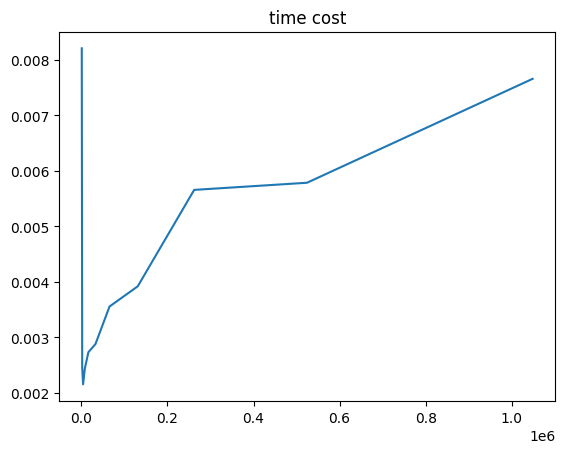

In [10]:
import matplotlib.pyplot as plt

plt.plot(T_list, time_list)
plt.title("time cost")


Text(0, 0.5, 'memory usage (in GB)')

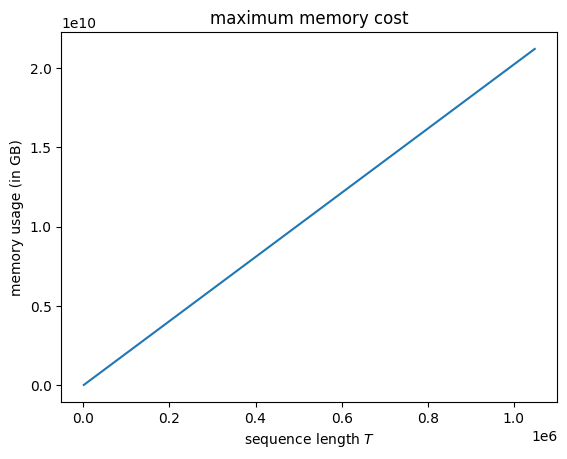

In [12]:
plt.plot(T_list, memory_list)
plt.title("maximum memory cost")
plt.xlabel(r"sequence length $T$")
plt.ylabel("memory usage (in GB)")

In [6]:
memory_list

[20717568,
 41418752,
 82837504,
 165675520,
 331350528,
 662700032,
 1325400064,
 2650800128,
 5301600256,
 10603200512,
 21206401024]

In [7]:
T_list

[1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576]

In [8]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   9216 MiB |  20224 MiB | 196515 MiB | 187299 MiB |
|       from large pool |   9216 MiB |  20224 MiB | 195881 MiB | 186665 MiB |
|       from small pool |      0 MiB |      6 MiB |    634 MiB |    634 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   9216 MiB |  20224 MiB | 196515 MiB | 187299 MiB |
|       from large pool |   9216 MiB |  20224 MiB | 195881 MiB |